# Sentiment Analysis on Twitter 2024 Election Data

In [2]:
!pip install langdetect

In [3]:
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata

%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

for dirname, _, filenames in os.walk('/data/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace

# Initialize Spark Session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Read the CSV files
tweets_kamala = spark.read.csv("kamalafinal.csv", header=True, inferSchema=True)
tweets_trump = spark.read.csv("trumpfinal.csv", header=True, inferSchema=True)

# Replace country names
tweets_kamala = tweets_kamala.withColumn(
    "country", regexp_replace("country", "United States", "United States of America")
)
tweets_trump = tweets_trump.withColumn(
    "country", regexp_replace("country", "United States", "United States of America")
)

# Show the data (Optional)
tweets_kamala.show()
tweets_trump.show()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/17 01:27:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/17 01:27:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------+--------------------+-------------+--------+---------+-----+----------+------------+
|          created_at|            tweet_id|               tweet|               likes|  retweet_count|              source|             user_id|           user_name|    user_screen_name|    user_description|      user_join_date|user_followers_count|      user_location|    lat|                long|         city| country|continent|state|state_code|collected_at|
+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------+--

In [5]:
from pyspark.sql.functions import col, unix_timestamp, to_date, datediff, lit, when, regexp_replace
from pyspark.sql import functions as F

# Convert date columns to timestamp or date format
tweets_kamala = tweets_kamala.withColumn("user_join_date", F.to_timestamp("user_join_date", "yyyy-MM-dd HH:mm:ss"))
tweets_trump = tweets_trump.withColumn("user_join_date", F.to_timestamp("user_join_date", "yyyy-MM-dd HH:mm:ss"))

tweets_kamala = tweets_kamala.withColumn("collected_at", F.to_timestamp("collected_at", "yyyy-MM-dd HH:mm:ss"))
tweets_trump = tweets_trump.withColumn("collected_at", F.to_timestamp("collected_at", "yyyy-MM-dd HH:mm:ss"))

tweets_kamala = tweets_kamala.withColumn("created_at", F.to_timestamp("created_at", "yyyy-MM-dd HH:mm:ss"))
tweets_trump = tweets_trump.withColumn("created_at", F.to_timestamp("created_at", "yyyy-MM-dd HH:mm:ss"))

# Extract date components or reformat
tweets_kamala = tweets_kamala.withColumn("created_at_r", F.date_format("created_at", "yyyy-MM-dd HH"))
tweets_trump = tweets_trump.withColumn("created_at_r", F.date_format("created_at", "yyyy-MM-dd HH"))

tweets_kamala = tweets_kamala.withColumn("created_at_r2", F.date_format("created_at", "yyyy-MM-dd"))
tweets_trump = tweets_trump.withColumn("created_at_r2", F.date_format("created_at", "yyyy-MM-dd"))

# Compute time differences in seconds
tweets_kamala = tweets_kamala.withColumn("time_diff",
                                         (unix_timestamp("collected_at") - unix_timestamp("created_at")) / 3600)
tweets_trump = tweets_trump.withColumn("time_diff",
                                       (unix_timestamp("collected_at") - unix_timestamp("created_at")) / 3600)

# Normalize likes and retweets
def normalize_column(df, column, time_diff_column):
    max_value = df.agg({column: "max"}).collect()[0][0]
    return df.withColumn(f"{column}_norm", col(column) / when(col(time_diff_column) == 0, lit(1)).otherwise(col(time_diff_column)))

tweets_kamala = normalize_column(tweets_kamala, "likes", "time_diff")
tweets_kamala = normalize_column(tweets_kamala, "retweet_count", "time_diff")

tweets_trump = normalize_column(tweets_trump, "likes", "time_diff")
tweets_trump = normalize_column(tweets_trump, "retweet_count", "time_diff")

# Show the results (Optional)
tweets_kamala.show()
tweets_trump.show()


24/12/17 01:27:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------+--------------------+-------------+--------+---------+-----+----------+------------+-------------+-------------+---------+----------+------------------+
|         created_at|            tweet_id|               tweet|               likes|  retweet_count|              source|             user_id|           user_name|    user_screen_name|    user_description|     user_join_date|user_followers_count|      user_location|    lat|                long|         city| country|continent|state|state_code|collected_at| created_at_r|created_at_r2|time_diff|likes_norm|retweet_count_norm|
+-------------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+----

/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/1266502645.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=columns_b, y=null_values_b, palette=kamala_colors, ax=ax[0])
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/1266502645.py:27: UserWarning: 
The palette list has fewer values (5) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=columns_b, y=null_values_b, palette=kamala_colors, ax=ax[0])
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/1266502645.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/1266502645.py:33: FutureWarning

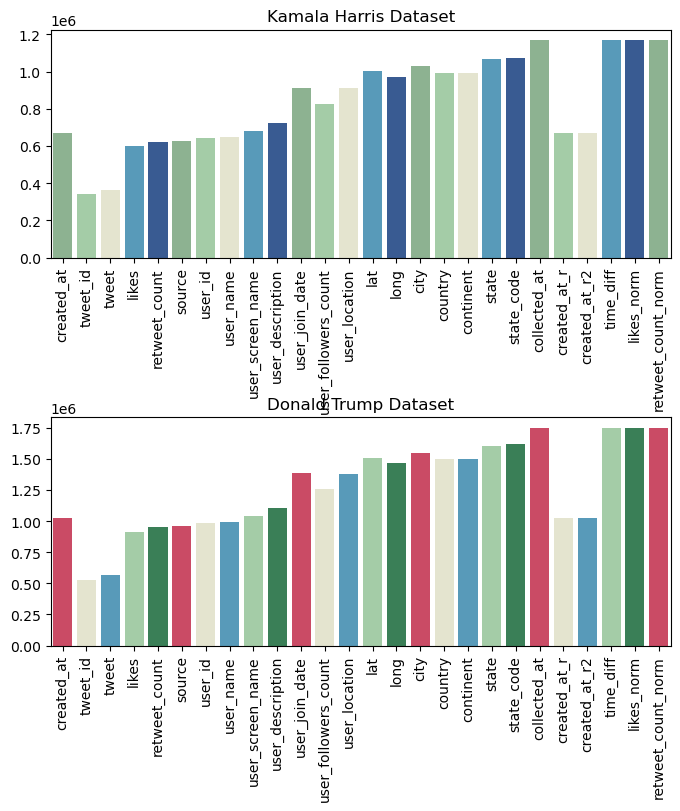

In [6]:
from pyspark.sql.functions import col, isnull, sum as spark_sum
import matplotlib.pyplot as plt
import seaborn as sns

# Compute null values directly in PySpark
na_vals_b = tweets_kamala.select(
    [(spark_sum(col(c).isNull().cast("int"))).alias(c) for c in tweets_kamala.columns]
)

na_vals_t = tweets_trump.select(
    [(spark_sum(col(c).isNull().cast("int"))).alias(c) for c in tweets_trump.columns]
)

# Convert Spark DataFrame columns to a list of tuples for plotting
na_vals_b_list = [(c, int(na_vals_b.first()[c])) for c in na_vals_b.columns if na_vals_b.first()[c] > 0]
na_vals_t_list = [(c, int(na_vals_t.first()[c])) for c in na_vals_t.columns if na_vals_t.first()[c] > 0]

# Prepare data for plotting
columns_b, null_values_b = zip(*na_vals_b_list) if na_vals_b_list else ([], [])
columns_t, null_values_t = zip(*na_vals_t_list) if na_vals_t_list else ([], [])

# Visualization
fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'hspace': 0.7})

# Kamala Harris Dataset Visualization
kamala_colors = ['#87B88C', '#9ED2A1', '#E7E8CB', '#48A0C9', '#2A58A1']
sns.barplot(x=columns_b, y=null_values_b, palette=kamala_colors, ax=ax[0])
ax[0].set_title('Kamala Harris Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

# Donald Trump Dataset Visualization
trump_colors = ['#DF3659', '#E7E8CB', '#48A0C9', '#9ED2A1', '#2E8B55']
sns.barplot(x=columns_t, y=null_values_t, palette=trump_colors, ax=ax[1])
ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.show()



In [7]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

tweets_kamala = pd.read_csv('kamalafinal.csv', lineterminator='\n', parse_dates=True)
tweets_trump = pd.read_csv('trumpfinal.csv', lineterminator='\n', parse_dates=True)

tweets_kamala['country'] = tweets_kamala['country'].replace({'United States':'United States of America'})
tweets_trump['country'] = tweets_trump['country'].replace({'United States':'United States of America'})

def normalise(x, y):
    x = np.array(pd.to_numeric(x, errors='coerce'))
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp = []
    for row in data:
        tmp = sid.polarity_scores(row)
        temp.append(tmp)
    return temp

tweets_kamala['user_join_date'] = pd.to_datetime(tweets_kamala['user_join_date'], errors='coerce')
tweets_trump['user_join_date'] = pd.to_datetime(tweets_trump['user_join_date'], errors='coerce')

tweets_kamala['collected_at'] = pd.to_datetime(tweets_kamala['collected_at'], errors='coerce')
tweets_trump['collected_at'] = pd.to_datetime(tweets_trump['collected_at'], errors='coerce')

tweets_kamala['created_at'] = pd.to_datetime(tweets_kamala['created_at'], errors='coerce')
tweets_trump['created_at'] = pd.to_datetime(tweets_trump['created_at'], errors='coerce')

tweets_kamala['created_at_r'] = tweets_kamala['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump['created_at_r'] = tweets_trump['created_at'].dt.strftime('%Y-%m-%d %H')

tweets_kamala['created_at_r2'] = tweets_kamala['created_at'].dt.strftime('%m-%d')
tweets_trump['created_at_r2'] = tweets_trump['created_at'].dt.strftime('%m-%d')

k_tdiff = (tweets_kamala['collected_at'] - tweets_kamala['created_at'])
t_tdiff = (tweets_trump['collected_at'] - tweets_trump['created_at'])

k_tdiff = (k_tdiff.dt.days * 24 + k_tdiff.dt.seconds / 3600)
t_tdiff = (t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

tweets_kamala['likes_norm'] = normalise(tweets_kamala['likes'], k_tdiff)
tweets_kamala['retweet_norm'] = normalise(tweets_kamala['retweet_count'], k_tdiff)

tweets_trump['likes_norm'] = normalise(tweets_trump['likes'], t_tdiff)
tweets_trump['retweet_norm'] = normalise(tweets_trump['retweet_count'], t_tdiff)

print(tweets_kamala['user_join_date'].isnull().sum(), 'missing user_join_date in Kamala data')
print(tweets_trump['user_join_date'].isnull().sum(), 'missing user_join_date in Trump data')

/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/570914483.py:5: DtypeWarning: Columns (1,3,6,11,13,14,20) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_kamala = pd.read_csv('kamalafinal.csv', lineterminator='\n', parse_dates=True)
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/570914483.py:6: DtypeWarning: Columns (1,3,6,11,13,14,20) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_trump = pd.read_csv('trumpfinal.csv', lineterminator='\n', parse_dates=True)


205 missing user_join_date in Kamala data
261 missing user_join_date in Trump data


In [8]:
# Visualisation args
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/598898946.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)


/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/4108114843.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_vals_b.index, y=na_vals_b['Null Values'], palette=kamala_colors, ax=ax[0])
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/4108114843.py:10: UserWarning: 
The palette list has fewer values (5) than needed (25) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=na_vals_b.index, y=na_vals_b['Null Values'], palette=kamala_colors, ax=ax[0])
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/4108114843.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_233

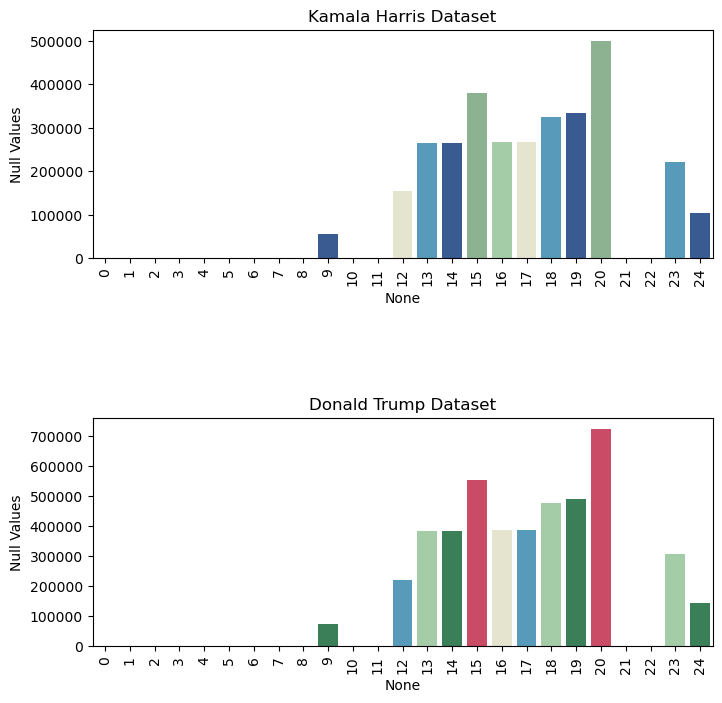

In [9]:

na_vals_b = tweets_kamala.isnull().sum().reset_index()
na_vals_b.columns = ['Column', 'Null Values']
na_vals_b = na_vals_b[na_vals_b['Null Values'] > 0]

na_vals_t = tweets_trump.isnull().sum().reset_index()
na_vals_t.columns = ['Column', 'Null Values']
na_vals_t = na_vals_t[na_vals_t['Null Values'] > 0]
fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'hspace': 0.7})
kamala_colors = ['#87B88C', '#9ED2A1', '#E7E8CB', '#48A0C9', '#2A58A1']
sns.barplot(x=na_vals_b.index, y=na_vals_b['Null Values'], palette=kamala_colors, ax=ax[0])
ax[0].set_title('Kamala Harris Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

trump_colors = ['#DF3659', '#E7E8CB', '#48A0C9', '#9ED2A1', '#2E8B55']
sns.barplot(x=na_vals_t.index, y=na_vals_t['Null Values'], palette=trump_colors, ax=ax[1])
ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.show()


/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/1152015674.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  source_df['country'].replace({'United States of America':'United States'}, inplace=True)
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/1152015674.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platXtab.loc[sourceslst, countryl

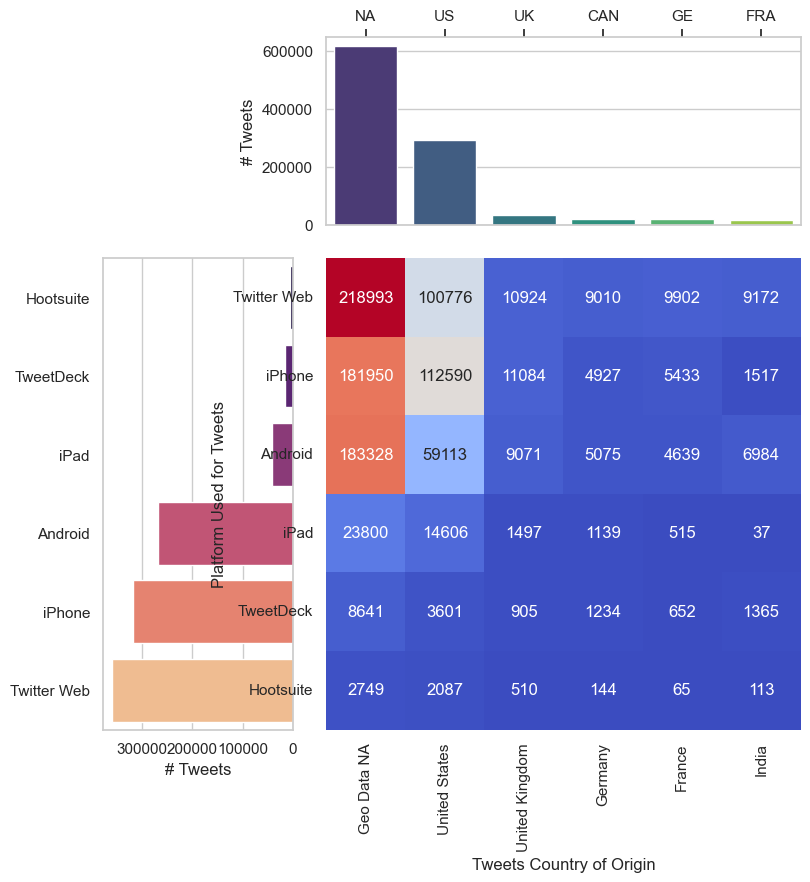

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


source_df=pd.concat([tweets_kamala[['source','tweet','country']].copy(),tweets_trump[['source','tweet','country']].copy()])
source_df['country'].replace({'United States of America':'United States'}, inplace=True)
source_df=source_df.fillna('Geo Data NA')
source_df=source_df.drop_duplicates()

sources=pd.DataFrame(source_df.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources=sources.reset_index()
sourceslst=sources.source.to_list()

country=pd.DataFrame(source_df.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country=country.reset_index()
countrylst=country.country.to_list()

platXtab=pd.DataFrame(source_df.groupby(['source','country'])['tweet'].count().unstack().fillna(0))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(2, 2, figsize=(9, 9),
                       gridspec_kw={'height_ratios': [2, 5], 'width_ratios': [2, 5], 'wspace': 0.1, 'hspace': 0.1})

hide_ax = ax[0, 0]
hide_ax.axis('off')

hm_ax = ax[1, 1]
sns.heatmap(platXtab.loc[sourceslst, countrylst], annot=True, fmt='.0f', cmap="coolwarm", cbar=False, ax=hm_ax)
hm_ax.set_xlabel('Tweets Country of Origin')
hm_ax.set_ylabel('Platform Used for Tweets')
hm_ax.set_yticklabels(('Twitter Web', 'iPhone', 'Android', 'iPad', 'TweetDeck', 'Hootsuite'), rotation=0)
bar_ax = ax[0, 1]
sns.barplot(x=platXtab.loc[sourceslst, countrylst].sum().index,
            y=platXtab.loc[sourceslst, countrylst].sum(), ax=bar_ax, palette='viridis')
bar_ax.set_xlabel('')
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_ylabel('# Tweets')
bar_ax.set_xticklabels(('NA', 'US', 'UK', 'CAN', 'GE', 'FRA'), rotation=0)
barh_ax = ax[1, 0]
sns.barplot(y=platXtab.loc[sourceslst, countrylst].sum(axis=1)[::-1].index,
            x=platXtab.loc[sourceslst, countrylst].sum(axis=1)[::-1], ax=barh_ax, palette='magma')
barh_ax.set_xlabel('# Tweets')
barh_ax.set_ylabel('')
barh_ax.set_yticklabels(('Hootsuite', 'TweetDeck', 'iPad', 'Android', 'iPhone', 'Twitter Web'), rotation=0)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
plt.show()


In [11]:
import geopandas as gpd
from shapely.geometry import Point

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
tweets_kamala[['lat', 'long']] = tweets_kamala[['lat', 'long']].apply(pd.to_numeric, errors='coerce')
tweets_trump[['lat', 'long']] = tweets_trump[['lat', 'long']].apply(pd.to_numeric, errors='coerce')
tmp = pd.concat([tweets_kamala[['lat', 'long']].copy(), tweets_trump[['lat', 'long']].copy()])
tmp = tmp.dropna()
geometry = [Point(xy) for xy in zip(tmp['long'], tmp['lat'])]
crs = {'init': 'EPSG:4326'}
geo_df = gpd.GeoDataFrame(tmp, crs=crs, geometry=geometry)
print(geo_df.head())


/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/2231099552.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


          lat        long                     geometry
0   25.774270  -80.193660   POINT (-80.19366 25.77427)
2   46.304036 -109.171431  POINT (-109.17143 46.30404)
4   36.701463 -118.755997  POINT (-118.75600 36.70146)
6   41.875562  -87.624421   POINT (-87.62442 41.87556)
11  37.572603  -85.155141   POINT (-85.15514 37.57260)


/opt/anaconda3/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


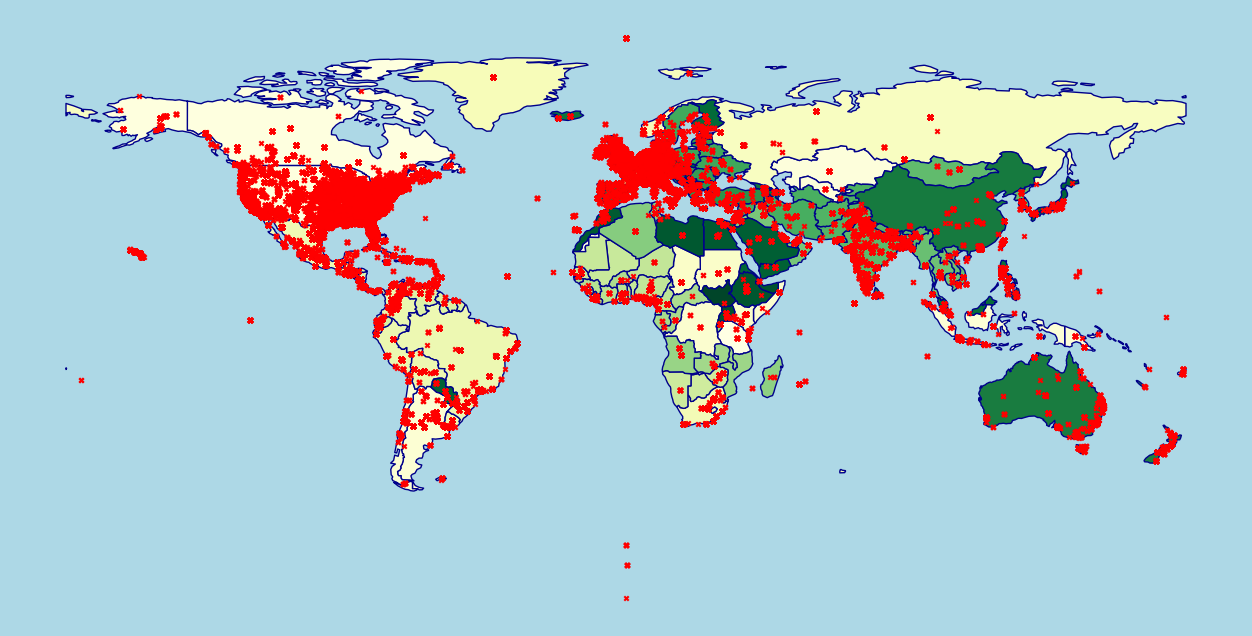

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(16, 8), facecolor='lightblue')
world = world[world.name != "Antarctica"]
world.plot(ax=ax, cmap='YlGn', edgecolors='darkblue')
geo_df.plot(ax=ax, markersize=10, color='red', marker='x')
ax.axis('off')
plt.show()



In [13]:
%%time
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

lang_df=pd.concat([tweets_kamala[['tweet','country']].copy(),tweets_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()
country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

<timed exec>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




CPU times: user 14.2 s, sys: 138 ms, total: 14.3 s
Wall time: 14.3 s


/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/2424051663.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=langXtab.loc[langslst, countrylst].sum().index,
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/2424051663.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_ax.set_xticklabels(['NA', 'US', 'GB', 'CAN', 'GE'], rotation=0)
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/2424051663.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=langXtab.loc[langslst, countrylst].sum(axis=1).values[::-1],
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn

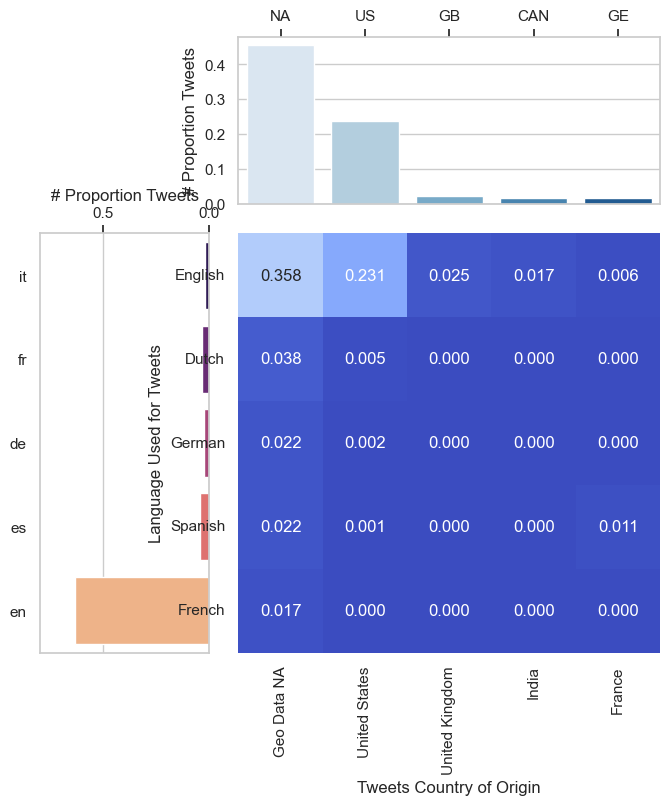

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(8, 8),
                       gridspec_kw={'height_ratios': [2, 5], 'width_ratios': [2, 5], 'wspace': 0.1, 'hspace': 0.1})
hide_ax = ax[0, 0]
hide_axes(hide_ax)
hm_ax = ax[1, 1]
sns.heatmap(langXtab.loc[langslst, countrylst], ax=hm_ax, annot=True, fmt='.3f', cmap='coolwarm', center=0.5, cbar=False)
hm_ax.set_yticklabels(('English', 'Dutch', 'German', 'Spanish', 'French'), rotation=0)
hm_ax.set_xlabel('Tweets Country of Origin')
hm_ax.set_ylabel('Language Used for Tweets')
bar_ax = ax[0, 1]
sns.barplot(x=langXtab.loc[langslst, countrylst].sum().index,
            y=langXtab.loc[langslst, countrylst].sum().values,
            ax=bar_ax, palette='Blues')
bar_ax.set_xlabel('')
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_xticklabels(['NA', 'US', 'GB', 'CAN', 'GE'], rotation=0)
bar_ax.set_ylabel('# Proportion Tweets')
barh_ax = ax[1, 0]
sns.barplot(x=langXtab.loc[langslst, countrylst].sum(axis=1).values[::-1],
            y=langslst[::-1], ax=barh_ax, palette='magma')
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.set_xlim([0.8, 0])
barh_ax.set_xlabel('# Proportion Tweets')
barh_ax.set_ylabel('')
barh_ax.set_yticklabels(langslst[::-1], rotation=0)

# Display the plot
plt.show()


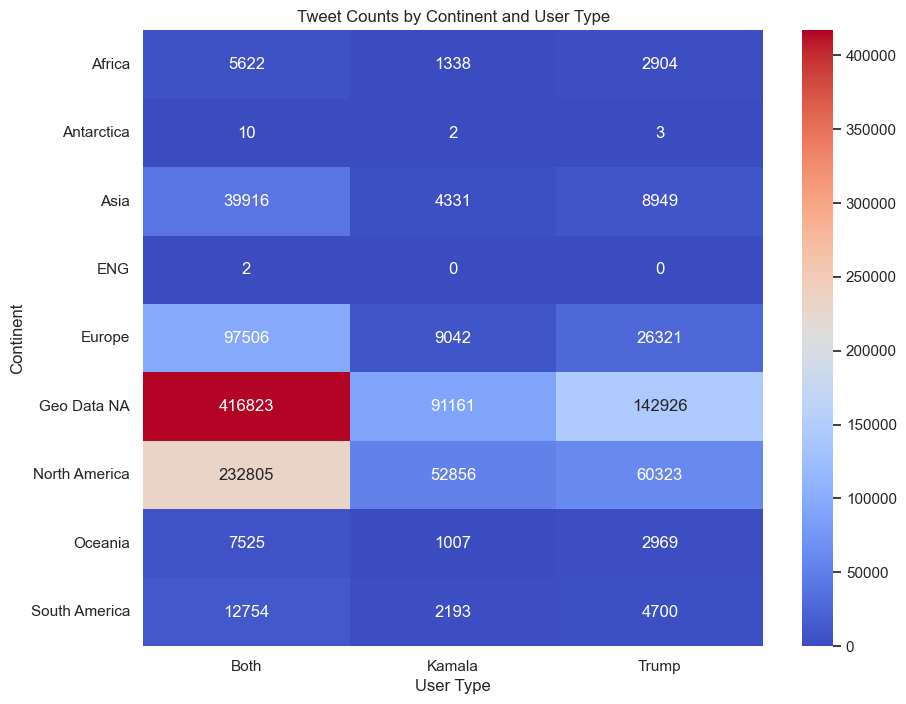

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tweets_kamala['user_id'] = tweets_kamala['user_id'].astype(str)
tweets_trump['user_id'] = tweets_trump['user_id'].astype(str)
common_ids = np.intersect1d(tweets_kamala.user_id, tweets_trump.user_id)
unique_b = tweets_kamala[~tweets_kamala.user_id.isin(common_ids)].copy()
common_b = tweets_kamala[tweets_kamala.user_id.isin(common_ids)].copy()
unique_t = tweets_trump[~tweets_trump.user_id.isin(common_ids)].copy()
common_t = tweets_trump[tweets_trump.user_id.isin(common_ids)].copy()

common_df = pd.concat([common_b, common_t]).drop_duplicates()
unique_b['usertype'] = 'Kamala'
unique_t['usertype'] = 'Trump'
common_df['usertype'] = 'Both'

cont_df = pd.concat([unique_b[['tweet', 'continent', 'usertype']].copy(),
                      unique_t[['tweet', 'continent', 'usertype']].copy(),
                      common_df[['tweet', 'continent', 'usertype']].copy()])
cont_df = cont_df.fillna('Geo Data NA')
usertype = pd.DataFrame(cont_df.groupby(['usertype'])['tweet'].count().sort_values(ascending=False))
usertype = usertype.reset_index()
userlst = usertype.usertype.tolist()

continent = pd.DataFrame(cont_df.groupby(['continent'])['tweet'].count().sort_values(ascending=False)[:6])
continent = continent.reset_index()
contlst = continent.continent.to_list()

contXtab = pd.crosstab(cont_df.continent, cont_df.usertype)

plt.figure(figsize=(10, 8))
sns.heatmap(contXtab, annot=True, cmap="coolwarm", fmt='d', cbar=True)
plt.title("Tweet Counts by Continent and User Type")
plt.xlabel('User Type')
plt.ylabel('Continent')
plt.show()


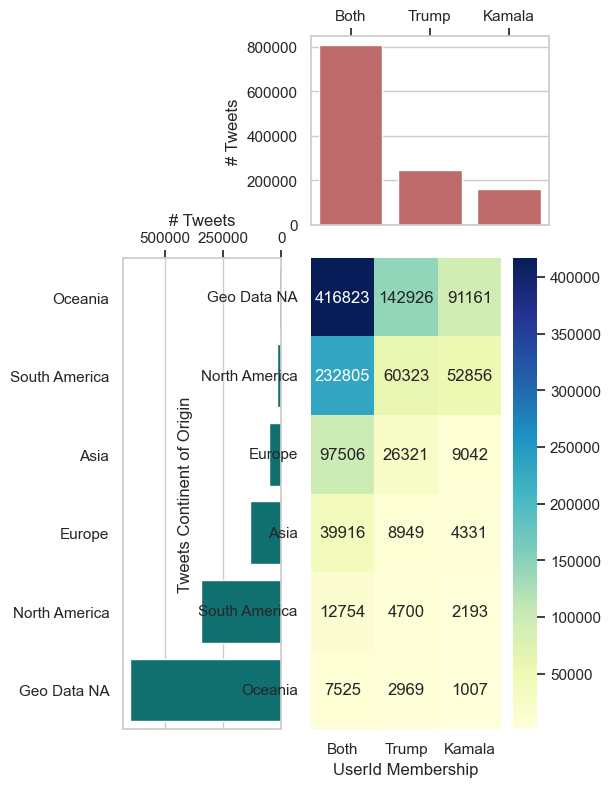

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(2, 2, figsize=(5.5, 9), gridspec_kw={'height_ratios': [2, 5], 'width_ratios': [2, 3], 'wspace': 0.15, 'hspace': 0.1})
hide_ax = ax[0, 0]
hide_ax.axis('off')
hm_ax = ax[1, 1]
sns.heatmap(contXtab.loc[contlst, userlst], annot=True, fmt='d', cmap="YlGnBu", cbar=True, ax=hm_ax)
hm_ax.set_xlabel('UserId Membership')
hm_ax.set_ylabel('Tweets Continent of Origin')
bar_ax = ax[0, 1]
sns.barplot(x=contXtab.loc[contlst, userlst].sum().index, y=contXtab.loc[contlst, userlst].sum(), ax=bar_ax, color='indianred')
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# Tweets')
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
barh_ax = ax[1, 0]
sns.barplot(y=contXtab.loc[contlst, userlst].sum(axis=1)[::-1].index, x=contXtab.loc[contlst, userlst].sum(axis=1)[::-1], ax=barh_ax, color='teal')
barh_ax.set_xlabel('# Tweets')
barh_ax.set_ylabel('')
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")

plt.show()


In [17]:
import numpy as np
import pandas as pd

tweets_kamala['created_at_r'] = tweets_kamala['created_at_r'].astype(str)
tweets_trump['created_at_r'] = tweets_trump['created_at_r'].astype(str)
common_creat = np.intersect1d(tweets_kamala.created_at_r, tweets_trump.created_at_r)
cnt_tkamala = tweets_kamala[tweets_kamala.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
cnt_ttrump = tweets_trump[tweets_trump.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
cnt_tkamala_df = pd.DataFrame(cnt_tkamala).reset_index()
cnt_ttrump_df = pd.DataFrame(cnt_ttrump).reset_index()
cnt_tkamala_df.columns = ['created_at_r', 'kamala_tweet_count']
cnt_ttrump_df.columns = ['created_at_r', 'trump_tweet_count']
merged_counts = pd.merge(cnt_tkamala_df, cnt_ttrump_df, on='created_at_r', how='outer')
print(merged_counts)


      created_at_r  kamala_tweet_count  trump_tweet_count
0    2024-10-15 00                 936                966
1    2024-10-15 01                 817                821
2    2024-10-15 02                 701                835
3    2024-10-15 03                 625                874
4    2024-10-15 04                 513                674
..             ...                 ...                ...
523  2024-11-05 20                2117               3556
524  2024-11-05 21                2106               3101
525  2024-11-05 22                1845               2986
526  2024-11-05 23                1798               6720
527            nan                 131                134

[528 rows x 3 columns]


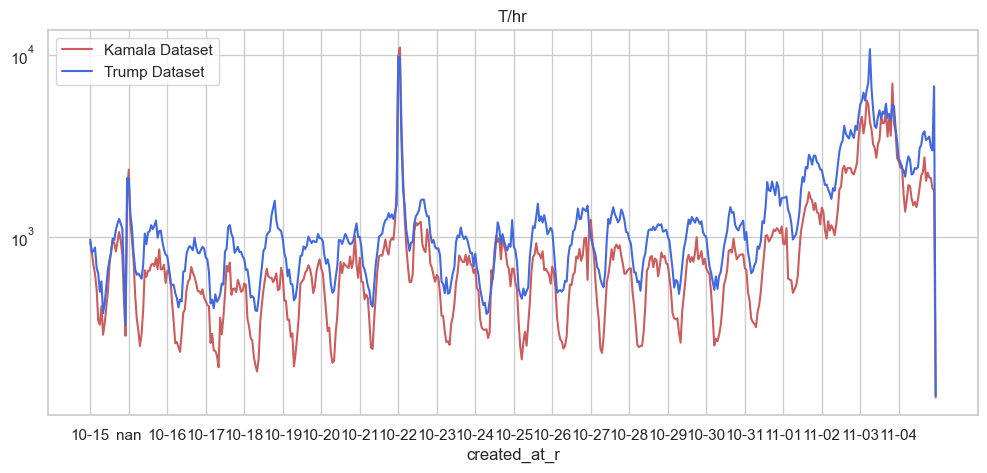

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.set_palette("dark:#5A9_r")
sns.lineplot(x=cnt_tkamala.index, y=cnt_tkamala.values, label='Kamala Dataset', color='indianred')
sns.lineplot(x=cnt_ttrump.index, y=cnt_ttrump.values, label='Trump Dataset', color='royalblue')
plt.title('T/hr')
xticks = range(0, len(cnt_tkamala.index), 24)
xticklabels = common_df['created_at'].dt.strftime('%m-%d').unique().tolist()
xticklabels = xticklabels[:len(xticks)]
plt.xticks(xticks, labels=xticklabels)
plt.yscale('log')
plt.show()


/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/32577145.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweets_kamala.groupby(['user_id'])['tweet'].count(), shade=True, color='mediumseagreen', label='Kamala Dataset')
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/32577145.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweets_trump.groupby(['user_id'])['tweet'].count(), shade=True, color='darkorange', label='Trump Dataset')


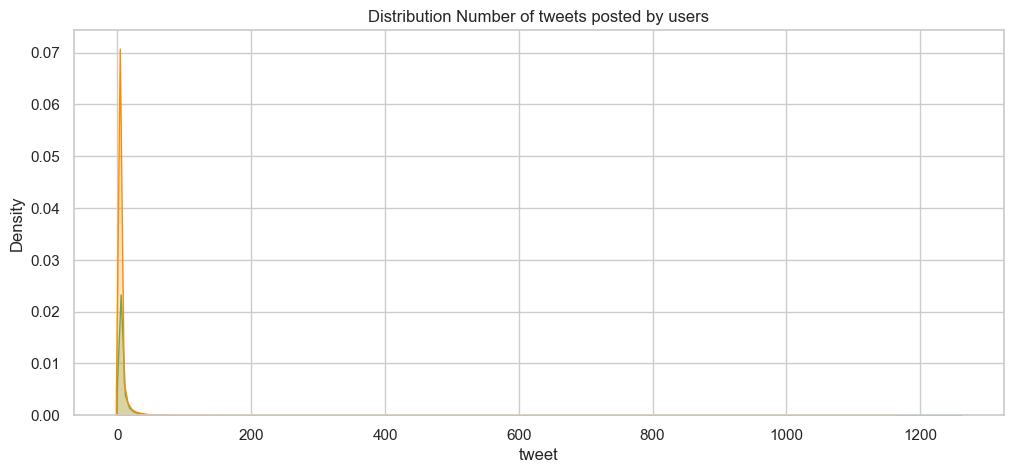

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

sns.set_palette("crest")
sns.kdeplot(tweets_kamala.groupby(['user_id'])['tweet'].count(), shade=True, color='mediumseagreen', label='Kamala Dataset')
sns.kdeplot(tweets_trump.groupby(['user_id'])['tweet'].count(), shade=True, color='darkorange', label='Trump Dataset')

plt.title('Distribution Number of tweets posted by users')
plt.show()


/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/3134785743.py:7: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(tweets_kamala['likes_norm'], bw=0.1, shade=True, color='indigo', label='Kamala Dataset')
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/3134785743.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweets_kamala['likes_norm'], bw=0.1, shade=True, color='indigo', label='Kamala Dataset')
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/3134785743.py:8: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
a

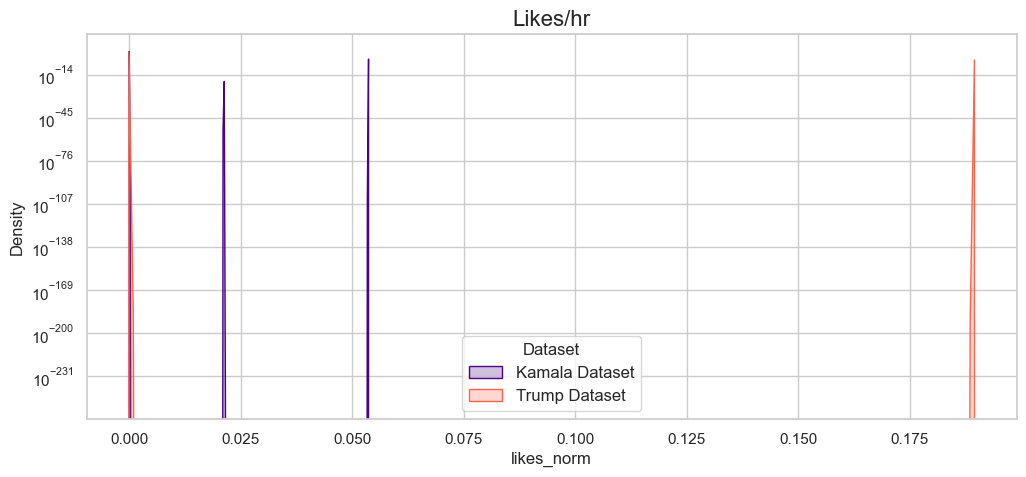

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

sns.set_palette("flare")
sns.kdeplot(tweets_kamala['likes_norm'], bw=0.1, shade=True, color='indigo', label='Kamala Dataset')
sns.kdeplot(tweets_trump['likes_norm'], bw=0.1, shade=True, color='tomato', label='Trump Dataset')

plt.title('Likes/hr', fontsize=16)
plt.legend(title='Dataset', fontsize=12)
plt.yscale('log')
plt.show()


/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/2802512776.py:7: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(tweets_kamala['retweet_norm'], bw=0.1, shade=True, color='mediumseagreen', label='Kamala Dataset')
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/2802512776.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweets_kamala['retweet_norm'], bw=0.1, shade=True, color='mediumseagreen', label='Kamala Dataset')
/var/folders/09/z4b8vf1j5gnb4sqltdm7hxh80000gn/T/ipykernel_23359/2802512776.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(tweets_kamal

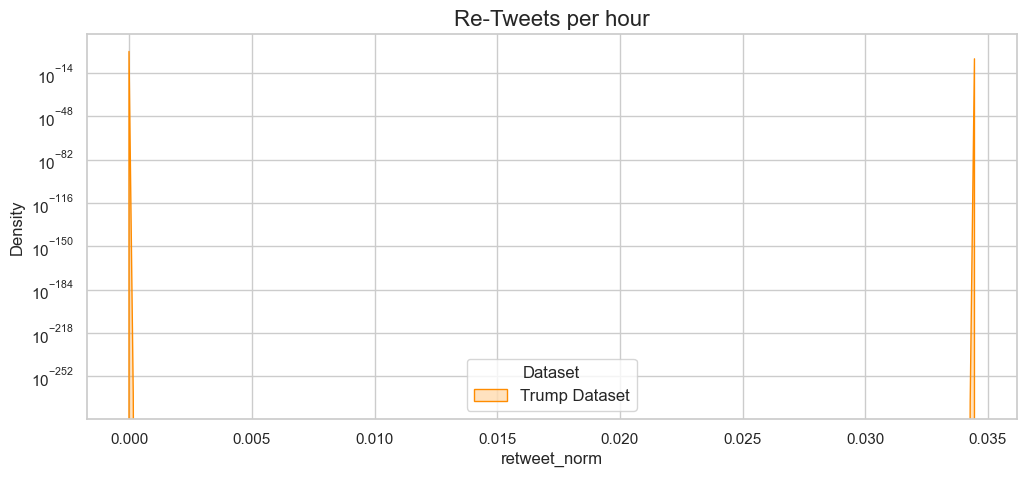

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

sns.set_palette("crest")
sns.kdeplot(tweets_kamala['retweet_norm'], bw=0.1, shade=True, color='mediumseagreen', label='Kamala Dataset')
sns.kdeplot(tweets_trump['retweet_norm'], bw=0.1, shade=True, color='darkorange', label='Trump Dataset')

plt.title('Re-Tweets per hour', fontsize=16)
plt.legend(title='Dataset', fontsize=12)
plt.yscale('log')
plt.show()


## N-GRAMS & SENTIMENT ANALYSIS

In [23]:
text1=tweets_kamala.loc[tweets_kamala['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']

Before the N-gram analysis we first must clean the tweets to remove stopwords, strings with "http" etc and then lemmatize the words.

In [25]:
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')

def clean1(sent):
    filtered_sent=""
    stopwords = nltk.corpus.stopwords.words('english')
    sent = (unicodedata.normalize('NFKD', sent)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    sent = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',sent)
    words=sent.split()
    for word in words:
        if word not in stopwords:
            filtered_sent=filtered_sent+' '+word
    return filtered_sent

def clean2(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words1 = clean2(''.join(str(text1.apply(clean1).tolist())))
words2 = clean2(''.join(str(text2.apply(clean1).tolist())))
words1[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sainishanth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sainishanth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['islandgirlprv',
 'bradbeauregardj',
 'meidastouch',
 'ccp',
 'thats',
 'always',
 'fine',
 'jack',
 'vijaya',
 'dickc']

In [26]:

kamala_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
kamala_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]
kamala_ngrams=pd.concat([kamala_2ngrams,kamala_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])

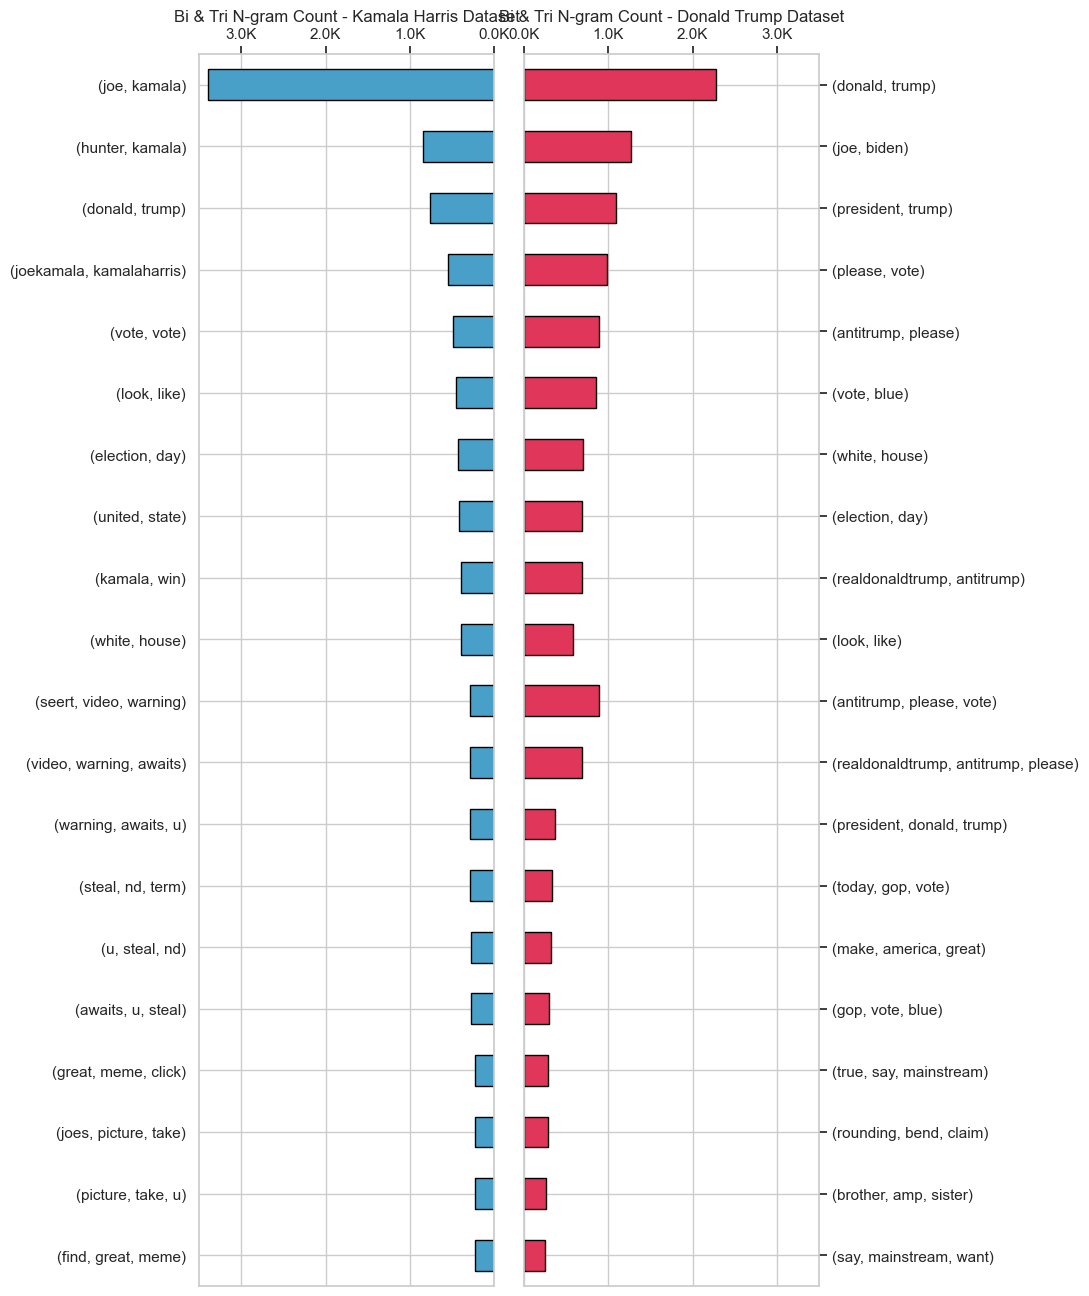

In [27]:
import matplotlib.pyplot as plt

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 16),
                       gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1, 'hspace': 0.1})

# Check if kamala_ngrams is not empty
if not kamala_ngrams.empty:
    barh_ax = ax[0]
    kamala_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[3], **barstyle)
    barh_ax.yaxis.set_label_position("left")
    barh_ax.xaxis.tick_top()
    barh_ax.xaxis.set_label_position("top")
    barh_ax.xaxis.set_major_formatter(formatterK2)
    barh_ax.set_xlim([0, 3500])
    barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
    barh_ax.set_xlabel('Bi & Tri N-gram Count - Kamala Harris Dataset')
    barh_ax.set_ylabel('')
else:
    ax[0].axis('off')  # Hide the plot if it's empty

# Check if trump_ngrams is not empty
if not trump_ngrams.empty:
    barh_ax = ax[1]
    trump_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[6], **barstyle)
    barh_ax.xaxis.tick_top()
    barh_ax.xaxis.set_label_position("top")
    barh_ax.xaxis.set_major_formatter(formatterK2)
    barh_ax.set_xlim([0, 3500])
    barh_ax.set_xlim(barh_ax.get_xlim())
    barh_ax.yaxis.tick_right()
    barh_ax.set_xlabel('Bi & Tri N-gram Count - Donald Trump Dataset')
    barh_ax.set_ylabel('')
else:
    ax[1].axis('off')  # Hide the plot if it's empty

plt.show()


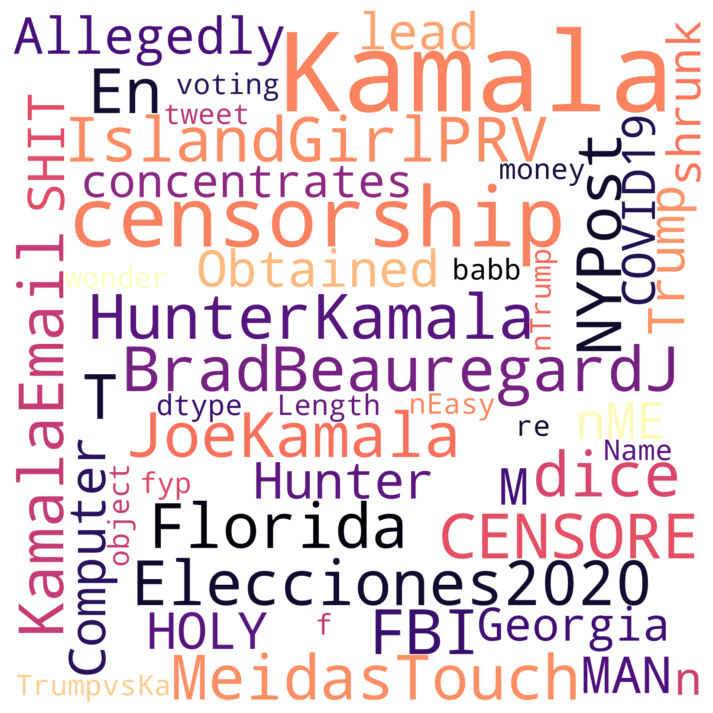

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
sns.set(style="whitegrid")
palette = sns.color_palette("magma", as_cmap=True)
plt.figure(figsize=(9, 9))

wc_b = WordCloud(stopwords=STOPWORDS,
                 background_color="white",
                 max_words=2000,
                 max_font_size=256,
                 random_state=42,
                 width=1600, height=1600,
                 colormap=palette)
wc_b.generate(str(text1.dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()


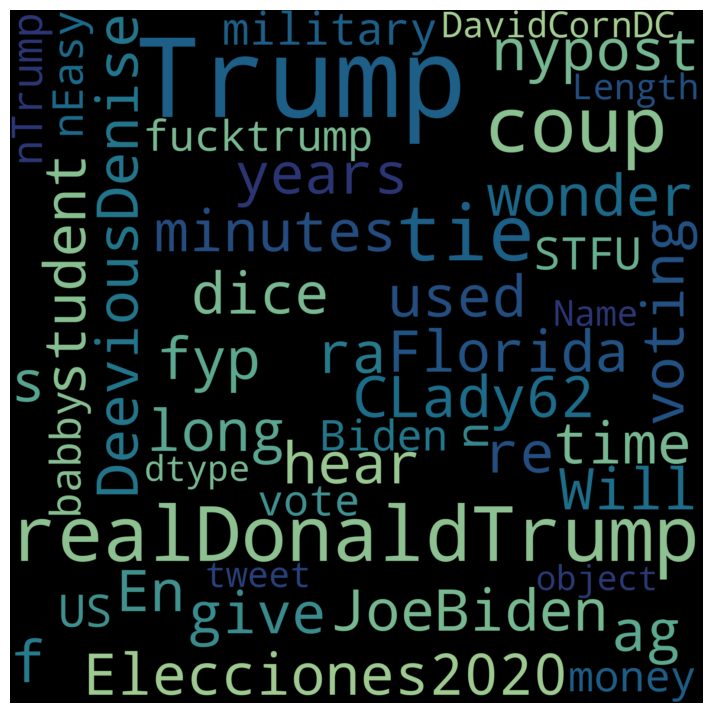

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

sns.set(style="whitegrid")
palette = sns.color_palette("crest", as_cmap=True)
plt.figure(figsize=(9, 9))

wc_t = WordCloud(stopwords=STOPWORDS,
                 background_color="black",
                 max_words=2000,
                 max_font_size=256,
                 random_state=42,
                 width=1600, height=1600,
                 colormap=palette)
wc_t.generate(str(text2.dropna()))
plt.imshow(wc_t, interpolation="bilinear")
plt.axis('off')
plt.show()


In [30]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("NGramAndSentimentAnalysis") \
    .getOrCreate()


24/12/17 01:40:54 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [31]:
from pyspark.sql.functions import col
# Replace "path_to_kamala_csv" and "path_to_trump_csv" with the actual file paths
tweets_kamala = spark.read.csv("kamalafinal.csv", header=True, inferSchema=True)
tweets_trump = spark.read.csv("trumpfinal.csv", header=True, inferSchema=True)


In [32]:
# Filter rows where 'country' is 'United States of America' and select the 'tweet' column
text1 = tweets_kamala.filter(col("country") == "United States of America").select("tweet")
text2 = tweets_trump.filter(col("country") == "United States of America").select("tweet")


In [33]:
from pyspark import SparkContext

# Verify if the SparkContext is active
print(SparkContext._active_spark_context)


<SparkContext master=local[*] appName=SentimentAnalysis>


In [34]:
tweets_kamala.printSchema()
tweets_trump.printSchema()


root
 |-- created_at: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- source: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_join_date: string (nullable = true)
 |-- user_followers_count: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- collected_at: string (nullable = true)

root
 |-- created_at: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet: string (nullable = true)
 |

In [35]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re
import unicodedata
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_text(sent):
    if not sent:
        return ""
    sent = (unicodedata.normalize('NFKD', sent)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    sent = re.sub(r"#.+|https.+|[^a-zA-Z\s]", "", sent)
    words = sent.split()
    filtered_sent = " ".join([word for word in words if word not in stopwords])
    return filtered_sent

clean_text_udf = udf(clean_text, StringType())

text1_cleaned = text1.withColumn("cleaned_tweet", clean_text_udf(col("tweet")))
text2_cleaned = text2.withColumn("cleaned_tweet", clean_text_udf(col("tweet")))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sainishanth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if not text:
        return ""
    words = text.split()
    lemmatized = " ".join([lemmatizer.lemmatize(word) for word in words])
    return lemmatized

lemmatize_udf = udf(lemmatize_text, StringType())

text1_lemmatized = text1_cleaned.withColumn("lemmatized_tweet", lemmatize_udf(col("cleaned_tweet")))
text2_lemmatized = text2_cleaned.withColumn("lemmatized_tweet", lemmatize_udf(col("cleaned_tweet")))


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sainishanth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
from pyspark.ml.feature import Tokenizer, NGram

# Tokenize the lemmatized text
tokenizer = Tokenizer(inputCol="lemmatized_tweet", outputCol="words")
text1_tokenized = tokenizer.transform(text1_lemmatized)
text2_tokenized = tokenizer.transform(text2_lemmatized)

# Generate N-Grams
ngram_2 = NGram(n=2, inputCol="words", outputCol="bigrams")
ngram_3 = NGram(n=3, inputCol="words", outputCol="trigrams")

text1_bigrams = ngram_2.transform(text1_tokenized)
text1_trigrams = ngram_3.transform(text1_tokenized)

text2_bigrams = ngram_2.transform(text2_tokenized)
text2_trigrams = ngram_3.transform(text2_tokenized)


In [38]:
# Count bi-grams
text1_bigrams_counts = (
    text1_bigrams.select("bigrams")
    .rdd.flatMap(lambda x: x[0])
    .map(lambda word: (word, 1))
    .reduceByKey(lambda a, b: a + b)
    .toDF(["bigram", "count"])
    .orderBy(col("count").desc())
)

text2_bigrams_counts = (
    text2_bigrams.select("bigrams")
    .rdd.flatMap(lambda x: x[0])
    .map(lambda word: (word, 1))
    .reduceByKey(lambda a, b: a + b)
    .toDF(["bigram", "count"])
    .orderBy(col("count").desc())
)

# Count tri-grams
text1_trigrams_counts = (
    text1_trigrams.select("trigrams")
    .rdd.flatMap(lambda x: x[0])
    .map(lambda word: (word, 1))
    .reduceByKey(lambda a, b: a + b)
    .toDF(["trigram", "count"])
    .orderBy(col("count").desc())
)

text2_trigrams_counts = (
    text2_trigrams.select("trigrams")
    .rdd.flatMap(lambda x: x[0])
    .map(lambda word: (word, 1))
    .reduceByKey(lambda a, b: a + b)
    .toDF(["trigram", "count"])
    .orderBy(col("count").desc())
)


In [39]:
# Collect top 10 n-grams for Kamala Harris
kamala_2gram_top10 = text1_bigrams_counts.limit(10).collect()
kamala_3gram_top10 = text1_trigrams_counts.limit(10).collect()

# Collect top 10 n-grams for Donald Trump
trump_2gram_top10 = text2_bigrams_counts.limit(10).collect()
trump_3gram_top10 = text2_trigrams_counts.limit(10).collect()

# Convert to lists
kamala_2gram_labels, kamala_2gram_counts = zip(*[(row["bigram"], row["count"]) for row in kamala_2gram_top10])
kamala_3gram_labels, kamala_3gram_counts = zip(*[(row["trigram"], row["count"]) for row in kamala_3gram_top10])
trump_2gram_labels, trump_2gram_counts = zip(*[(row["bigram"], row["count"]) for row in trump_2gram_top10])
trump_3gram_labels, trump_3gram_counts = zip(*[(row["trigram"], row["count"]) for row in trump_3gram_top10])


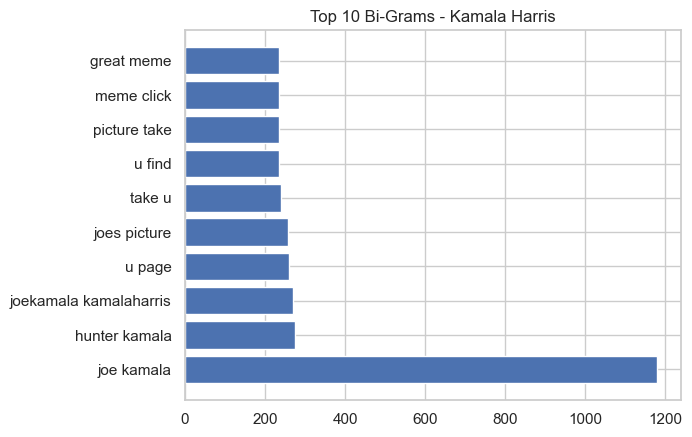

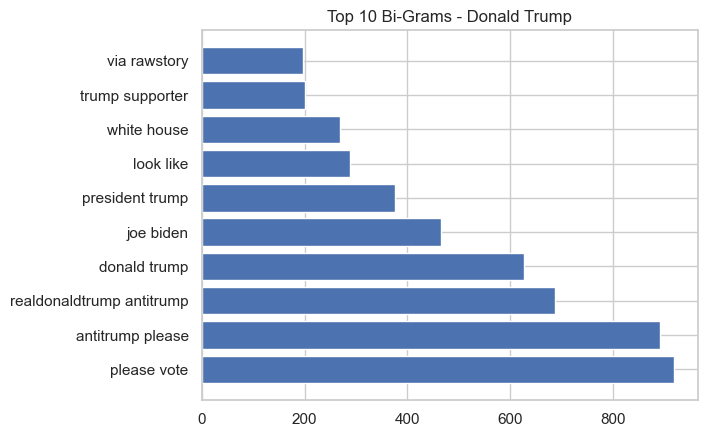

In [40]:
import matplotlib.pyplot as plt

# Kamala Harris N-Grams
plt.barh(kamala_2gram_labels, kamala_2gram_counts)
plt.title("Top 10 Bi-Grams - Kamala Harris")
plt.show()

# Donald Trump N-Grams
plt.barh(trump_2gram_labels, trump_2gram_counts)
plt.title("Top 10 Bi-Grams - Donald Trump")
plt.show()


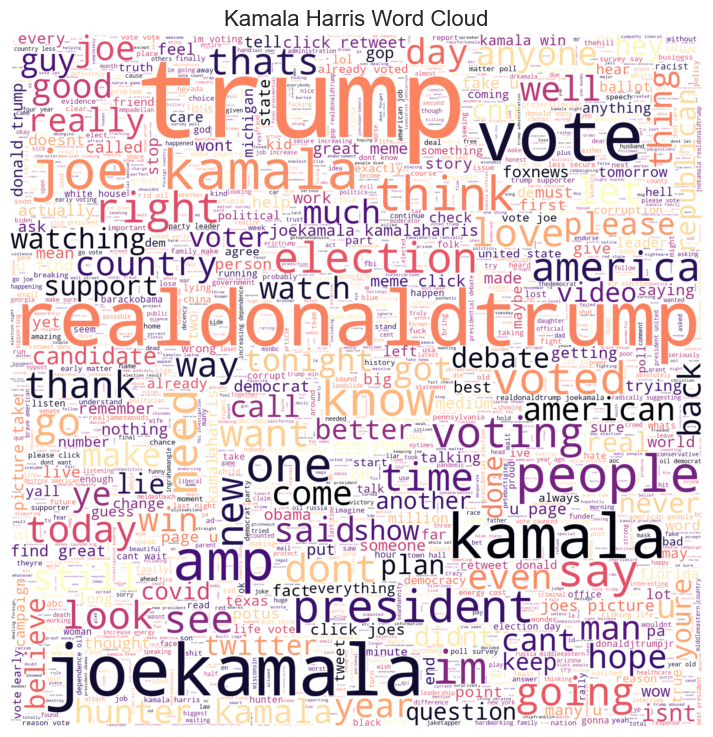

In [41]:
from wordcloud import WordCloud, STOPWORDS

# Generate text for Kamala Harris
kamala_text = " ".join(text1_lemmatized.select("lemmatized_tweet").rdd.flatMap(lambda x: x).collect())

# Create WordCloud for Kamala Harris
wc_kamala = WordCloud(
    stopwords=STOPWORDS,
    background_color="white",
    max_words=2000,
    max_font_size=256,
    random_state=42,
    width=1600,
    height=1600,
    colormap="magma"
).generate(kamala_text)

# Plot WordCloud
plt.figure(figsize=(9, 9))
plt.imshow(wc_kamala, interpolation="bilinear")
plt.axis("off")
plt.title("Kamala Harris Word Cloud", fontsize=16)
plt.show()


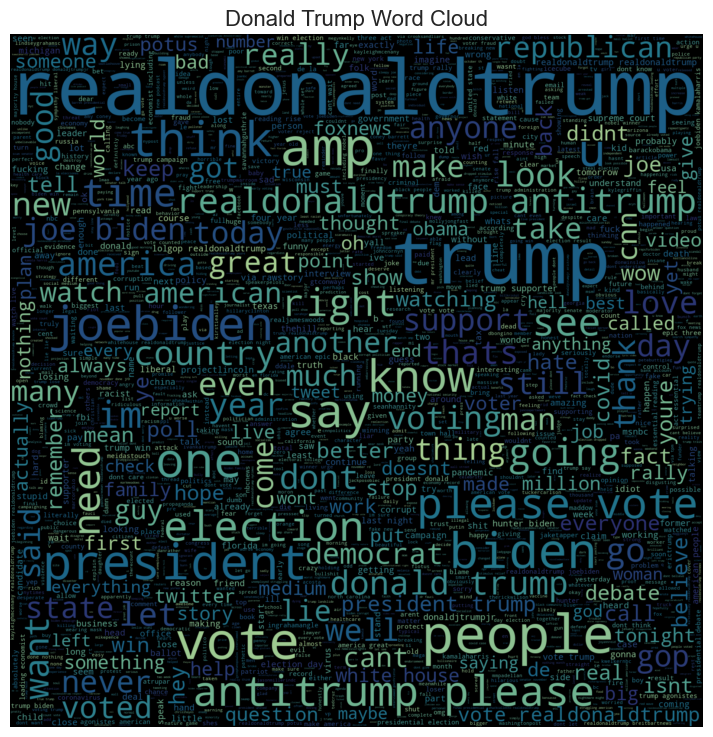

In [42]:
# Generate text for Donald Trump
trump_text = " ".join(text2_lemmatized.select("lemmatized_tweet").rdd.flatMap(lambda x: x).collect())

# Create WordCloud for Donald Trump
wc_trump = WordCloud(
    stopwords=STOPWORDS,
    background_color="black",
    max_words=2000,
    max_font_size=256,
    random_state=42,
    width=1600,
    height=1600,
    colormap="crest"
).generate(trump_text)

# Plot WordCloud
plt.figure(figsize=(9, 9))
plt.imshow(wc_trump, interpolation="bilinear")
plt.axis("off")
plt.title("Donald Trump Word Cloud", fontsize=16)
plt.show()


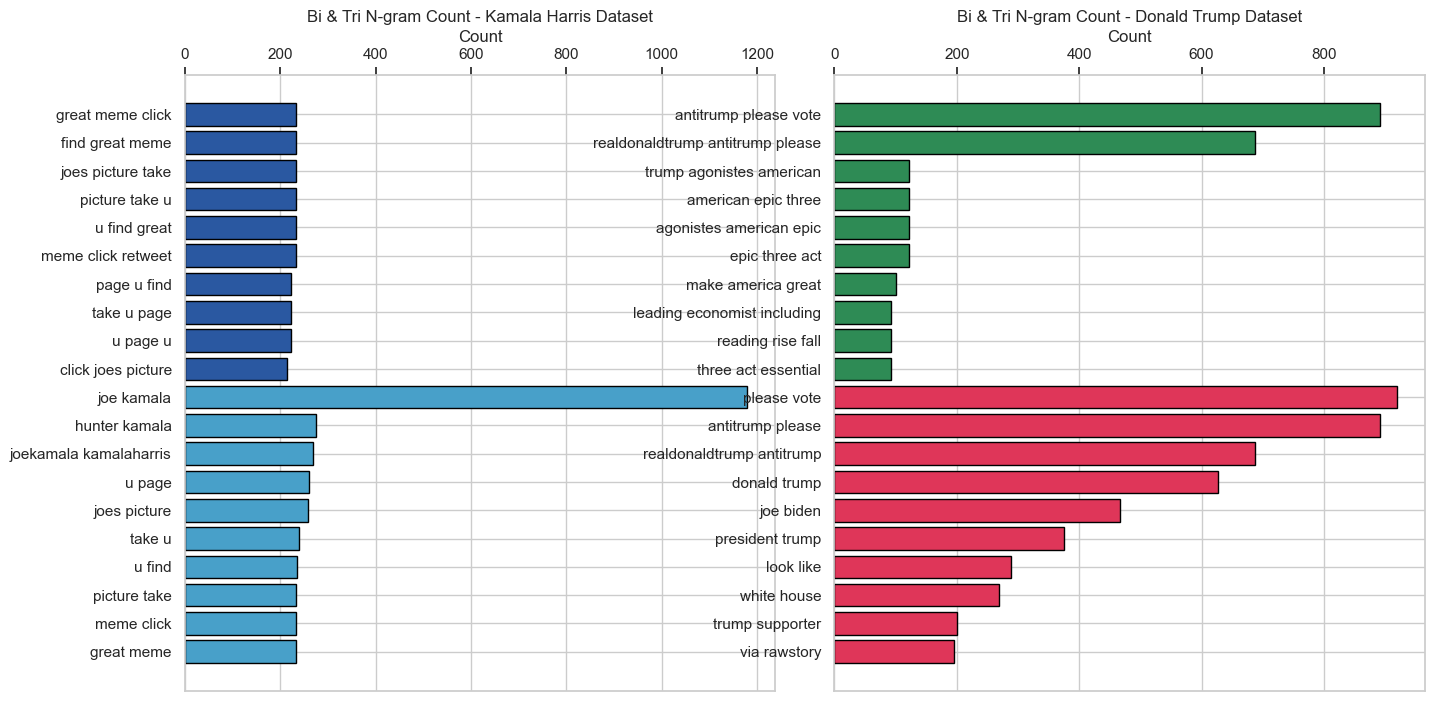

In [43]:
# Combine Bi-grams and Tri-grams for Kamala Harris
kamala_combined_labels = kamala_2gram_labels[::-1] + kamala_3gram_labels[::-1]
kamala_combined_counts = kamala_2gram_counts[::-1] + kamala_3gram_counts[::-1]
kamala_combined_colors = [barcolors[3]] * len(kamala_2gram_labels) + [barcolors[4]] * len(kamala_3gram_labels)

# Combine Bi-grams and Tri-grams for Donald Trump
trump_combined_labels = trump_2gram_labels[::-1] + trump_3gram_labels[::-1]
trump_combined_counts = trump_2gram_counts[::-1] + trump_3gram_counts[::-1]
trump_combined_colors = [barcolors[6]] * len(trump_2gram_labels) + [barcolors[5]] * len(trump_3gram_labels)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

# Kamala Harris N-Grams
if len(kamala_combined_labels) > 0:
    barh_ax = ax[0]
    barh_ax.barh(kamala_combined_labels, kamala_combined_counts, color=kamala_combined_colors, **barstyle)
    barh_ax.set_title("Bi & Tri N-gram Count - Kamala Harris Dataset")
    barh_ax.xaxis.set_label_position("top")
    barh_ax.xaxis.tick_top()
    barh_ax.set_xlabel("Count")
else:
    ax[0].axis('off')  # Hide plot if empty

# Donald Trump N-Grams
if len(trump_combined_labels) > 0:
    barh_ax = ax[1]
    barh_ax.barh(trump_combined_labels, trump_combined_counts, color=trump_combined_colors, **barstyle)
    barh_ax.set_title("Bi & Tri N-gram Count - Donald Trump Dataset")
    barh_ax.xaxis.set_label_position("top")
    barh_ax.xaxis.tick_top()
    barh_ax.set_xlabel("Count")
else:
    ax[1].axis('off')  # Hide plot if empty

# Show the combined plots
plt.show()
